<a href="https://colab.research.google.com/github/judeha/addnoise/blob/main/NER_Model_Evaluation_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install transformers
!pip install evaluate
!pip install seqeval

In [65]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import evaluate
import torch
import json
from pprint import pformat
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
#NEW
import pandas as pd
import numpy as np

pred_vals = pd.DataFrame(columns=['index', 'max_index', 'max_value'])

In [66]:
class TokenizerInfoSlow():
  """
  Given string of text, creates an object containing information on
  the characters, tokens, and words of that text;
  this class is used for slow tokenizers, which do not have some
  of this functionality already written
  - A word is defined to be any consecutive sequence of alphanumeric characters
    or any single non-alphanumeric and non-whitespace character
  - All newlines are converted to spaces before running tokenizer to ensure
    they are not included in the tokens; however, the method text() still
    returns the original text
  - The special classifcation and separator tokens (CLS and SEP) are added at
    the beginning and end of the token sequence, respectively, as is expected
    by BERT-based models
  """

  @staticmethod
  def __token_len(token):
    """
    Given a token as a string from the tokenizer,
    returns the number of characters in that token after undoing the
    modifications that the tokenizer makes to the token, so that only
    the characters originally present in the text are counted
    """
    # Note that the below only handles the slow tokenizer used for BERTweet, since
    # the rest of the models tested use fast tokenizers and therefore use
    # the class TokenizerInfoFast
    # Other slow tokenizers will need different ways of finding token length
    return 1 if token == tokenizer.unk_token else len(token.replace('@@', ''))

  def __init__(self, text):
    # (The purpose of each instance variable is described in the subsequent methods in this class)
    self.__text = text
    # Ensure tokenizer ignores newlines
    text = text.replace('\n', ' ')
    # Number of characters in each token; None for CLS and SEP tokens at beginning and end
    token_lengths = [None] + [self.__token_len(t) for t in tokenizer.tokenize(text)] + [None]
    # Number of tokens that make up the text
    token_count = len(token_lengths)
    self.__input_ids = tokenizer(text)['input_ids']
    self.__word_ids = [[] for _ in range(token_count)]
    self.__word_to_chars = []
    self.__char_to_word = []
    self.__token_to_chars = [None] * token_count
    self.__char_to_token = [None] * len(text)

    start_char_id = 0  # Index of starting character in current word
    word_id = 0  # Index of current word
    is_word_end = [False] * len(text)  # For each character in text, whether that character is the final character of a word
    text_with_final_space = text + ' '  # Extra space added to end to ensure final word is properly processed
    final_index = len(text)  # Index of the extra space
    for i, c in enumerate(text_with_final_space):
      if c.isalnum():  # Alphanumeric character -- indicates we are in the middle of a word
        # Record index of word that the current character is in
        self.__char_to_word.append(word_id)

      else:  # Non-alphanumeric character -- indicates word boundary
        if i > start_char_id:  # Indicates there was a word being processed before current character
          # Since we have reached word boundary, the previous character finished the word
          is_word_end[i-1] = True
          # Record indices of starting and ending characters of that word
          self.__word_to_chars.append((start_char_id, i))
          # Update word index for current character
          word_id += 1

        if i == final_index:  # Reached end -- don't process the extra space
          self.__word_count = word_id
          break

        # Record index of word that the current character is in; None if character is whitespace
        self.__char_to_word.append(word_id if not c.isspace() else None)

        if not c.isspace():  # Current character is neither alphanumeric nor whitespace (punctuation, etc.)
          # The current character constitutes a single-character word
          is_word_end[i] = True
          # Record current character as its own word
          self.__word_to_chars.append((i, i+1))
          # Update word index for subsequent character
          word_id += 1

        # Set starting character of subsequent word
        start_char_id = i + 1

    start_char_id = 0  # Index of starting charcter in current token
    token_char_count = 0  # Number of characters already processed in current token
    token_id = 1  # Index of the current token -- starts at 1 to account for CLS at index 0
    token_char_goal = token_lengths[token_id]  # Total number of characters in current token
    last_token_id = token_count - 2  # Index of the last token before SEP
    for i, c in enumerate(text):
      # Ignore whitespace
      if c.isspace():
        start_char_id = i + 1
        continue
      self.__char_to_token[i] = token_id
      token_char_count += 1
      # Reached character that ends either a token or a word
      if token_char_count == token_char_goal or is_word_end[i]:
        # Add association between token index and word index
        self.__word_ids[token_id].append(self.__char_to_word[i])
        # If end of token, update/reset token properties
        if token_char_count == token_char_goal:
          self.__token_to_chars[token_id] = (start_char_id, i+1)
          if token_id == last_token_id:
            break
          start_char_id = i + 1
          token_id += 1
          token_char_count = 0
          token_char_goal = token_lengths[token_id]

  def text(self):
    """
    Returns the original string of text that was given when instantiating this class
    """
    return self.__text

  def input_ids(self):
    """
    Returns an integer list containing the numerical representations of
    each token when the text is run through the tokenizer;
    these are the token represenations that are passed as input to the NER model
    """
    return self.__input_ids

  def word_ids(self):
    """
    Returns list that indicates, for each token index,
    the indices of all the words that contain that token
    (so that each element of the list is itself a list)
    """
    return self.__word_ids

  def word_to_chars(self, i):
    """
    Given word index, returns tuple containing the indices
    of the starting and ending characters of that word
    (with start included and end excluded, as is standard)
    """
    return self.__word_to_chars[i]

  def char_to_word(self, i):
    """
    Given character index, returns index of word that contains that character;
    None when character not in any word
    """
    return self.__char_to_word[i]

  def token_to_chars(self, i):
    """
    Given token index, returns tuple containing the indices
    of the starting and ending characters of that token
    (with start included and end excluded, as is standard)
    """
    return self.__token_to_chars[i]

  def char_to_token(self, i):
    """
    Given character index, returns index of token that contains that character;
    None when token not in any word
    """
    return self.__char_to_token[i]
  
  def word_count(self):
    """
    Returns number of words in text
    """
    return self.__word_count

In [67]:
class TokenizerInfoFast():
  """
  Same as TokenizerInfoSlow, but for fast tokenizers
  - A word is defined however the specified tokenizer defines it
  - word_to_chars() and token_to_chars() return a CharSpan object rather
    than a tuple, but this object is subscriptable in the same way as a tuple
  """
  def __init__(self, text):
    self.__text = text
    self.__inputs = tokenizer(text.replace('\n', ' '))

  def text(self):
    return self.__text

  def input_ids(self):
    return self.__inputs['input_ids']

  def word_ids(self):
    return [[i] for i in self.__inputs.word_ids()]

  def word_to_chars(self, i):
    return self.__inputs.word_to_chars(i)

  def char_to_word(self, i):
    return self.__inputs.char_to_word(i)

  def token_to_chars(self, i):
    return self.__inputs.token_to_chars(i)

  def char_to_token(self, i):
    return self.__inputs.char_to_token(i)
  
  def word_count(self):
    return 1 + next((elt for elt in reversed(self.__inputs.word_ids()) if elt is not None), -1)

In [68]:
def get_raw_predictions(input_ids_matrix, attention_mask_matrix):
  """
  Given input token IDs and attention masks as 2D PyTorch tensors,
  returns the NER model's predictions as a 3D list of logits
  representing the likelihood of each token being a particular entity
  """
  # Run each matrix row separately if split_input_matrices is True
  if split_input_matrices:
    return [
      model(input_ids=ii_row.unsqueeze(0), attention_mask=am_row.unsqueeze(0)).logits.tolist()[0]
      for ii_row, am_row in zip(input_ids_matrix, attention_mask_matrix)
    ]
  else:
    return model(input_ids=input_ids_matrix, attention_mask=attention_mask_matrix).logits.tolist()

In [146]:
def get_pred_dict_partitions(inputs):
  """
  Given inputs from tokenizer, returns the model's predictions using partition method
  """
  if model_max_length % 4 != 0:
    raise Exception(f'partition method relies on model_max_length being a multiple of 4, but model_max_length = {model_max_length}')
  # List of numbers that tokens are converted into
  input_ids = inputs.input_ids()
  # PyTorch tensor of input_ids divided into partitions of the maximum size
  # that the NER model can handle; padding added for incomplete partitions
  partitioned_input_ids = torch.empty(0, model_max_length)
  # Attention masks for each token in each partition
  attention_mask = torch.empty(0, model_max_length)
  # Index of SEP in input_ids
  last = len(input_ids) - 1
  # Start constructing partitions at the first token after CLS
  start = 1 
  while True:
    # Index of the token at which to end the current partition
    end = start + max_len_single_sentence
    # Padding tokens to add to this partition
    padding_len = max(0, end - last)
    padding = [tokenizer.pad_token_id] * padding_len
    # Construct partition with tokens in interval [start, end)
    # Add CLS, SEP, and padding tokens as well
    new_partition = [tokenizer.cls_token_id] + input_ids[start : min(end, last)] + [tokenizer.sep_token_id] + padding
    # Attend to all tokens except padding tokens
    new_attention_mask = [1] * (min(end, last) - start + 2) + [0] * padding_len
    # Add to tensors of all partitions and attention masks
    partitioned_input_ids = torch.cat((partitioned_input_ids, torch.tensor([new_partition])))
    attention_mask = torch.cat((attention_mask, torch.tensor([new_attention_mask])))
    if end >= last:
      # Reached last token
      break
    # Find next partition, which overlaps
    start += max_len_single_sentence // 2
  partitioned_input_ids = partitioned_input_ids.int().to(device)
  attention_mask = attention_mask.to(device)
  # Note that padding_len now stores the number of padding tokens in the last partition

  # Raw model predictions on all partitions
  partition_predictions = get_raw_predictions(partitioned_input_ids, attention_mask)
  # List of raw predictions for each token after reassembling partitions
  predictions = []
  # Index of last partition
  last_part_i = len(partition_predictions) - 1
  for part_i, part_pred in enumerate(partition_predictions):
    # Since partitions overlap, take only the predictions for the tokens closest to the center of each partition
    # In general, this means the tokens in the first one-fourth and last one-fourth
    # of each partition are ignored; only the center one-half is used
    # The exceptions are the first partition, which must have all its beginning tokens used,
    # and the last partition, which must have all its ending tokens used (excluding padding)
    start = 1 if part_i == 0 else 1 + model_max_length // 4
    end = model_max_length - padding_len - 1 if part_i == last_part_i \
      else model_max_length - model_max_length // 4
    predictions.extend(part_pred[start:end])
  # Add list items corresponding to CLS and SEP tokens, although
  # there are no prediction results to assign to them
  predictions = [None] + predictions + [None]

  # List of dictionaries of predictions, converted into IOB2 format
  # Predictions of 'O' are not included
  pred_dict = []
  for i, pred in enumerate(predictions):
    if pred == None:
      continue
    #NEW
    #print('pred')
    #print(pred)
    #print('max(pred)')
    #print(max(pred))
    #print('pred.index(max(pred))')
    #print(pred.index(max(pred)))
    entity = id2label[pred.index(max(pred))]
    if entity != 'O':
      pred_dict.append({
        'token index': i,
        'entity': entity
      })
      #NEW
      global pred_vals
      df = pd.DataFrame({'index':[i],
                         'max_index':[pred.index(max(pred))],
                         'max_value':[max(pred)]})
      pred_vals=pred_vals.append(df)  
  
  #NEW
  #print('pred_dict')
  #print(pred_dict)
  return pred_dict

In [147]:
def get_pred_dict_paragraphs(inputs):
  """
  Given inputs from tokenizer, returns the model's predictions using paragraph method
  """
  # Text of article (cleaned)
  text = inputs.text()
  # List of numbers that tokens are converted into
  input_ids = inputs.input_ids()
  # paragraph_input_ids is a PyTorch tensor containing input_ids divided into paragraphs if needed,
  # and if not, containing only one element consisting of an undivided input_ids
  if len(input_ids) <= model_max_length:
    # No paragraphs needed -- contains undivided input_ids
    paragraph_input_ids = torch.tensor([input_ids])
    # Attend to all tokens
    attention_mask = torch.tensor([[1] * len(input_ids)])
    # Entire article considered to be one "paragraph"
    paragraphs = [(1, len(input_ids) - 1)]
  else:
    # input_ids to be divided into paragraphs
    # List of indices of start and end tokens of each paragraph
    paragraphs = []
    # Token index that starts current paragraph
    start_token = 1
    # Index of SEP token in input_ids
    last_token = len(input_ids) - 1
    is_last_paragraph = False
    while not is_last_paragraph:
      # Character index that starts current paragraph
      start_char = inputs.token_to_chars(start_token)[0]
      # Character index that ends current paragraph
      end_char = text.find(paragraph_delimiter, start_char)
      if end_char == -1:
        # No more paragraph delimiters
        end_char = len(text)
      # Token index that ends current paragraph
      end_token = None
      # Push end_char beyond whitespaces to get end_token
      while end_token is None:
        if end_char == len(text):
          is_last_paragraph = True
          end_token = last_token
          break
        end_token = inputs.char_to_token(end_char)
        end_char += 1
      # Record paragraph
      paragraphs.append((start_token, end_token))
      # Update start_token for next paragraph
      start_token = end_token
    
    # Number of tokens in the longest paragraph (excluding special tokens)
    longest_paragraph_length = max(end - start for start, end in paragraphs)
    if longest_paragraph_length > max_len_single_sentence:
      raise Exception(f'paragraph exceeds token limit: paragraph has {longest_paragraph_length + 2} tokens (after special tokens are added), but model_max_length = {model_max_length}')

    paragraph_input_ids = torch.empty(0, longest_paragraph_length + 2)
    attention_mask = torch.empty(0, longest_paragraph_length + 2)
    for start, end in paragraphs:
      # Padding tokens to add to this paragraph
      padding = [tokenizer.pad_token_id] * (longest_paragraph_length - (end - start))
      # Construct paragraph with tokens in interval [start, end)
      # Add CLS, SEP, and padding tokens as well
      new_paragraph = [tokenizer.cls_token_id] + input_ids[start : end] + [tokenizer.sep_token_id] + padding
      # Attend to all tokens except padding tokens
      new_attention_mask = [1] * (end - start + 2) + [0] * (longest_paragraph_length - (end - start))
      # Add to tensors of all paragraphs and attention masks
      paragraph_input_ids = torch.cat((paragraph_input_ids, torch.tensor([new_paragraph])))
      attention_mask = torch.cat((attention_mask, torch.tensor([new_attention_mask])))
  
  paragraph_input_ids = paragraph_input_ids.int().to(device)
  attention_mask = attention_mask.to(device)

  # Raw model predictions on all paragraphs
  paragraph_predictions = get_raw_predictions(paragraph_input_ids, attention_mask)
  # List of raw predictions for each token after reassembling paragraphs
  predictions = []
  for pred, (start, end) in zip(paragraph_predictions, paragraphs):
    # Keep only the tokens we care about; ignore CLS, SEP, and padding tokens
    predictions.extend(pred[1 : 1+end-start])
  # Add list items corresponding to CLS and SEP tokens, although
  # there are no prediction results to assign to them
  predictions = [None] + predictions + [None]

  # List of dictionaries of predictions, converted into IOB2 format
  # Predictions of 'O' are not included
  pred_dict = []
  for i, pred in enumerate(predictions):
    if pred == None:
      continue
    entity = id2label[pred.index(max(pred))]
    if entity != 'O':
      pred_dict.append({
        'token index': i,
        'entity': entity
      })
      #NEW
      global pred_vals
      df = pd.DataFrame({'index':[i],
                         'max_index':[pred.index(max(pred))],
                         'max_value':[max(pred)]})
      pred_vals = pred_vals.append(df)  
  
  return pred_dict

In [148]:
def get_pred_dict(inputs):
  """
  Given inputs from tokenizer, returns NER model's predictions as a list of dictionaries,
  each with the following keys:
  - 'token index': index of the token to which the predicted label is assigned
  - 'entity': the predicted named entity label for that token, in IOB2 format; predictions of 'O' are not included
  As noted, the list excludes tokens predicted as 'O'.
  """
  if evaluation_method == 'partitions':
    return get_pred_dict_partitions(inputs)
  elif evaluation_method == 'paragraphs':
    return get_pred_dict_paragraphs(inputs)
  else:
    raise Exception(f'"{evaluation_method}" is an invalid setting for evaluation_method')

In [72]:
def clean_ocr_text(text, basic, remove_list):
  """
  Given 
  - string of text,
  - whether (True/False) to do only basic newline cleaning, and
  - the list of characters to remove (if basic=False),
  returns a tuple containing
  (1) the text after applying the desired cleaning operations, and
  (2) a list of integers indicating, for each character in original text,
      how many positions to the left that character is offset to arrive at cleaned text.
  When basic is False, also replaces 'é', 'ï', 'ﬁ', and 'ﬂ'.
  In all cases, hyphen-newline ("-\n") sequences are removed, lone newlines are
  converted to spaces, and sequences of consecutive newlines are kept unchanged
  in order to indicate paragraph boundaries.
  """
  # Code to deal with unwanted symbols
  cleaned_text = text.replace("-\n", "")
  if not basic:
    cleaned_text = cleaned_text.replace("é", "e").replace("ï", "i").replace("ﬁ", "fi").replace("ﬂ", "fl")
    cleaned_text = cleaned_text.translate({ord(x): '' for x in remove_list})
    
  # Code to deal with newline and double newline
  z = 0
  while z < (len(cleaned_text)-1):  # Check from the first to before last index
        if cleaned_text[z] == "\n" and cleaned_text[z+1] == "\n":
            z += 2
        elif cleaned_text[z] == "\n" and cleaned_text[z+1] != "\n":
            temp = list(cleaned_text)
            temp[z] = " "
            cleaned_text = "".join(temp)
            z += 1
        else:
            z += 1
  if cleaned_text[len(cleaned_text)-1] == "\n" and cleaned_text[len(cleaned_text)-2] != "\n":  # Check if the last index is a new line
    temp = list(cleaned_text)
    temp[len(cleaned_text)-1] = " "
    cleaned_text = "".join(temp)  

  # Code to adjust offsets  
  offsets = []
  cur_offset = 0
  i = 0
    
  while i < len(text):
    if i+1 < len(text) and text[i:i+2] == '-\n':  # Found removed hyphen-newline
      offsets.extend([cur_offset, cur_offset + 1])  # Make removed characters correspond with next character
      cur_offset += 2  # Update offset for subsequent characters
      i += 2  # Push forward beyond removed characters
    else:
      offsets.append(cur_offset)  # Record offset of non-removed character
      i += 1  # Process next character
  
  if not basic:            
    for j in range(len(text)):
      if text[j] == "ﬁ" or text[j] == "ﬂ": 
          for a in range(j+1,len(text)):
              offsets[a] = offsets[a] - 1  # Negative offsets for every char after a char replaced with two chars
      elif text[j] in remove_list:
          for a in range(j+1,len(text)):  # Positive offsets for every char after a removed char
              offsets[a] = offsets[a] + 1
      else:
          j += 1
         
  return cleaned_text, offsets

In [73]:
def display_labels(words, gt_labels, pred_labels):
  """
  Returns string displaying words alongside associated ground truth and predicted labels
  """
  spacing = max(24, 4 + max([len(word) for word in words]))
  gap1 = ' ' * (spacing - 5)
  gap2 = ' ' * (spacing - 12)
  display = 'words' + gap1 + 'ground truth' + gap2 + 'predictions' + '\n'
  for word, gt_label, pred_label in zip(words, gt_labels, pred_labels):
    gap1 = ' ' * (spacing - len(word))
    gap2 = ' ' * (spacing - len(gt_label))
    display += word + gap1 + gt_label + gap2 + pred_label + '\n'
  return display

In [74]:
def get_labels(article_index, label_comparison_file):
  """
  Given index of article in JSON file,
  returns list of ground truth labels and list of model's predicted labels for each word in article;
  as a side effect, writes the results to label_comparison_file for human inspection
  """

  # Text of article after cleaning, and list of character offsets translating original text to cleaned text
  text, offsets = clean_ocr_text(gt_full_file[article_index]['data']['text'], basic=basic_text_cleaning, remove_list=remove_list)
  # Results of running tokenizer
  inputs = TokenizerInfoFast(text) if tokenizer.is_fast else TokenizerInfoSlow(text)
  # List associating each token with the indices of the words it's found in
  word_ids = inputs.word_ids()
  # Number of words in text
  word_count = inputs.word_count()
  # List of words in text
  words = [text[inputs.word_to_chars(i)[0] : inputs.word_to_chars(i)[1]]
           for i in range(word_count)]

  # Extract label information from ground truth file
  gt_dict_spans = []
  gt_dict_spans_unprocessed = [
    elt['value']
    for elt in gt_full_file[article_index]['annotations'][0]['result']
    if elt['type'] == 'labels'
  ]
  for elt in gt_dict_spans_unprocessed:
    # Keep only desired labels
    if elt['labels'][0] in desired_labels:
      # Add offsets to account for cleaned text
      gt_dict_spans.append({
        'start': elt['start'] - offsets[elt['start']],
        'end': elt['end'] - offsets[elt['end']],
        'entity': elt['labels'][0]
      })

  # Get ground truth labels:
  # Split gt_dict_spans so that gt_dict contains labels on a word-by-word basis
  # rather than containing the entire span of labeled text representing a named entity;
  # 'B-' and 'I-' prefixes are added to indicate spans
  gt_dict = []
  for elt in gt_dict_spans:
    word_id = None
    start = elt['start']
    # Find the first word in current ground truth label (in case label begins with whitespace)
    while word_id is None and start < elt['end']:
      word_id = inputs.char_to_word(start)
      start += 1
    if word_id is None:
      continue # Ignore label that contains only whitespace
    is_beginning = True
    # Separately record each word in label
    while word_id < word_count and inputs.word_to_chars(word_id)[0] < elt['end']:
      gt_dict.append({
        'word index': word_id,
        'entity': ('B-' if is_beginning else 'I-') + elt['entity']
      })
      word_id += 1
      is_beginning = False

  # Dictionary associating word ids with ground truth labels
  word_to_gt = {elt['word index']: elt['entity'] for elt in gt_dict}
  # List of ground truth labels; gt_labels[i] is label for word at index i, including 'O' label
  gt_labels = [word_to_gt.get(word_id, 'O') for word_id in range(word_count)]

  # Labels predicted by model
  pred_dict = get_pred_dict(inputs)
  # Keep only desired labels
  pred_dict = [elt for elt in pred_dict if elt['entity'][2:] in desired_labels]

  # Dictionary associating word ids with predicted labels
  word_to_pred = {}
  for elt in pred_dict:
    # Consider each word that the current token is part of
    for word_id in word_ids[elt['token index']]:
      # Only the first label assigned to a word is used
      if word_id not in word_to_pred:
        word_to_pred[word_id] = elt['entity']
  # List of predicted labels; pred_labels[i] is label for word at index i, including 'O' label
  pred_labels = [word_to_pred.get(word_id, 'O') for word_id in range(word_count)]

  # Remove non-alphanumeric words
  words2 = []
  gt_labels2 = []
  pred_labels2 = []
  gt_carry_begin = False
  pred_carry_begin = False
  for word, gt, pred in zip(words, gt_labels, pred_labels):
    if any(c.isalnum() for c in word):
      words2.append(word)
      gt_labels2.append(gt if not gt_carry_begin or gt == 'O' else 'B' + gt[1:])
      pred_labels2.append(pred if not pred_carry_begin or pred == 'O' else 'B' + pred[1:])
      gt_carry_begin = False
      pred_carry_begin = False
    # Carry beginning tag to next token if the current tag is a beginning but is being removed
    elif gt[0] == 'B':
      gt_carry_begin = True
    elif pred[0] == 'B':
      pred_carry_begin = True

  # Add information to label comparison file
  label_comparison_file.write(
    f'Article #{article_index}\n'
    + display_labels(words2, gt_labels2, pred_labels2) + '\n'
    + ('-' * 100 + '\n') * 3 + '\n'
  )

  return gt_labels2, pred_labels2

In [177]:
def run_evaluation():
  # Fill lists with labels from all articles
  ground_truth = []
  predictions = []
  print(f'Evaluating {len(gt_full_file)} articles:')
  with open(label_comparison_file_name, 'w') as label_comparison_file:
    for article_index in tqdm(range(len(gt_full_file))):
      gt, pred = get_labels(article_index, label_comparison_file)
      ground_truth.append(gt)
      predictions.append(pred)
      #NEW
      #global ground_vals
      #for ele in gt:
        #temp = pd.DataFrame({'label': ele})
        #ground_vals = ground_vals.append(temp)

  # Lists of named entities
  # Cares only about whether something is a named entity, ignoring its type
  # (i.e., ignoring the distinction between PER vs. ORG vs. LOC vs. MISC)
  ground_truth_general = [[entity[0] for entity in article] for article in ground_truth]
  predictions_general = [[entity[0] for entity in article] for article in predictions]

  # Calculate F1 score, precision, recall, accuracy
  metrics = metric.compute(predictions=predictions, references=ground_truth)
  metrics_general = metric.compute(predictions=predictions_general, references=ground_truth_general)
  summary = (
    f'Model name: {model_name}\n'
    + f'Evaluation method: {f"{model_max_length}-token " if evaluation_method == "partitions" else ""}{evaluation_method}\n\n'
    + f'Overall F1 score (stringent): {metrics["overall_f1"]}\n'
    + f'Overall F1 score (ignoring entity type): {metrics_general["overall_f1"]}\n\n'
    + f'All metrics:\n{pformat(metrics)}\n\n'
    + f'All metrics (ignoring entity type):\n{pformat(metrics_general)}'
  )
  # Print summary and add to file
  print('\n' + summary)
  with open(label_comparison_file_name, 'r') as f:
    existing_contents = f.read()
  with open(label_comparison_file_name, 'w') as f:
    f.write(summary + '\n\n\n\n')
    f.write(existing_contents)

# Parameters

* ``model_name``:
  * Name of NER model to evaluate (such as a model name from Hugging Face)

* ``tokenizer_name``:
  * Name of tokenizer to use with NER model
  * This is often identical to model_name, but this is different for some models (which happens when the creator of the model didn't specify this themselves)

* ``id2label``:
  * Dictionary mapping label IDs to label names for each model
  * Set this to ``None`` in order to use the default value given by the model in ``model.config.id2label``
  * However, if the creator of the model set ``model.config.id2label`` incorrectly, you will need to figure it out yourself and assign the correct dictionary to ``id2label``

* ``evaluation method``:
  * Specifies how to split articles in order to deal with token limits
  * Can be set to either ``'partitions'`` or ``'paragraphs'``:
    * ``'partitions'``: the text is split into overlapping partitions with a fixed number of tokens (specified in model_max_length)
    * ``'paragraphs'``: the text is split into paragraphs

* ``model_max_length``:
  * If using partition method, set this to be the number of tokens to place in each partition (must be multiple of 4)
  * If using paragraph method, simply specify the maximum number of tokens the model can handle at a time
  * Do not set this in any case to be larger than the maximum number of tokens the NER model is set up to handle

* ``ground_truth_file_name``:
  * Path to JSON file with ground truth labels from Label Studio

* ``label_comparison_file_name``:
  * Path to text file in which to record evaluation results and side-by-side comparisons of ground truth and predicted labels
  * This file is created by the program for you to inspect the results -- you don't need to provide this yourself
  * (If you only provide a file name without specifying a path, you can find the file by clicking on the folder icon on the left sidebar in Colab.)

* ``desired_labels``:
  * The set of labels that will be considered when evaluating the model
  * All other labels (in either the ground truth or the model predictions), if any, are ignored (considered to be O)

* ``split_input_matrices``:
  * Usually set this to False
  * However, if the notebok is running out of memory, set this to True in order to run each row of the input matrices separately through the model, which increases runtime but gets around the memory issue
  * This setting does not affect the final results -- it only trades off space vs. time while executing the code

* ``basic_text_cleaning``:
  * True: only handle newlines during text-cleaning stage; False: handle newlines and other characters

* ``remove_list``:
  * List of characters to remove if ``basic_text_cleaning`` is set to False
  * (This is ignored if ``basic_text_cleaning`` is True)

If you test a model not listed here that uses a "slow" tokenizer, update the static method __token_len() in the class TokenizerInfoSlow.

Note that the following *warning* from the tokenizer can be safely ignored (this message will be printed when you run evaluation):

``"Token indices sequence length is longer than the specified maximum sequence length for this model. Running this sequence through the model will result in indexing errors"``

This program is set up to deal with that issue.

(However, if you get an *exception*, then there is actually something wrong.)

Re-run this cell to change the parameters.

In [195]:
# NER model
model_name = 'Davlan/bert-base-multilingual-cased-ner-hrl'
tokenizer_name = model_name
#CHANGE
#id2label = None
id2label = {0: 'O', 1: 'B-MISC', 2:'B-MISC', 3: 'B-PER', 4: 'I-PER', 5: 'B-ORG', 6: 'I-ORG', 7: 'B-LOC', 8: 'I-LOC'}
#default: {0: 'O', 1: 'B-DATE', 2: 'I-DATE', 3: 'B-PER', 4: 'I-PER', 5: 'B-ORG', 6: 'I-ORG', 7: 'B-LOC', 8: 'I-LOC'}
#davlan config, {0: 'B-LOC', 1: 'B-MISC', 2:'B-ORG', 3: 'B-PER', 4: 'I-LOC', 5: 'I-MISC', 6: 'I-ORG', 7: 'I-PER', 8: 'O'}

# Evaluation method
evaluation_method = 'partitions'
model_max_length = 512

# Files
ground_truth_file_name = '/content/drive/My Drive/Dell Lab/ground_truth_672_articles/ground_truth_672_articles_test.json'
label_comparison_file_name = 'label comparisons.txt'

# Settings
desired_labels = 'PER', 'ORG', 'LOC', 'MISC'
split_input_matrices = False
basic_text_cleaning = True
remove_list = ["#","/","*","@","~","¢","©","®","°"]

# Evaluation

Re-run this cell after changing ``model_name`` or ``tokenizer_name``.

If you made no change to ``model_name`` or ``tokenizer_name``, then you can just skip to the last cell to save a few seconds. (But there's also nothing wrong with re-running this cell every time.)

In [80]:
# Set GPU, if available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# The specified NER model
model = AutoModelForTokenClassification.from_pretrained(model_name).to(device)
# The specified tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
# Metric for evaluation (F1 score, etc.)
metric = evaluate.load('seqeval')

Run this cell to perform evaluation according to the parameters specified in the Parameters section.

In [197]:
# Get contents of JSON file with ground truth labels
with open(ground_truth_file_name, 'r') as f:
  gt_full_file = json.load(f)

# model_max_length excluding special tokens
max_len_single_sentence = model_max_length - 2
# Sequence that indicates paragraph break in text
paragraph_delimiter = '\n\n'

# Dictionary mapping label IDs to label names for each model
# If None, simply use the dictionary provided by the model
if id2label is None:
  id2label = model.config.id2label


# Perform model evaluation
run_evaluation()

Evaluating 101 articles:


100%|██████████| 101/101 [00:51<00:00,  1.95it/s]



Model name: Davlan/bert-base-multilingual-cased-ner-hrl
Evaluation method: 512-token partitions

Overall F1 score (stringent): 0.6813186813186813
Overall F1 score (ignoring entity type): 0.7424325811777654

All metrics:
{'LOC': {'f1': 0.7552083333333333,
         'number': 550,
         'precision': 0.7225913621262459,
         'recall': 0.7909090909090909},
 'MISC': {'f1': 0.0, 'number': 310, 'precision': 0.0, 'recall': 0.0},
 'ORG': {'f1': 0.5919439579684763,
         'number': 263,
         'precision': 0.5487012987012987,
         'recall': 0.6425855513307985},
 'PER': {'f1': 0.791537025513379,
         'number': 785,
         'precision': 0.7737226277372263,
         'recall': 0.8101910828025478},
 'overall_accuracy': 0.9520377456625924,
 'overall_f1': 0.6813186813186813,
 'overall_precision': 0.7159353348729792,
 'overall_recall': 0.649895178197065}

All metrics (ignoring entity type):
{'_': {'f1': 0.7424325811777654,
       'number': 1908,
       'precision': 0.7815758980301275

In [ ]:
#NEW
#DISCERN MISC VS OTHER LABELS

#pred_vals contains the index of model predictions excluding 'O'
#ground truth indices don't line up well

In [173]:
pred_vals.head()

,index,max_index,max_value
0,12,3,7.866304
0,13,4,6.097297
0,14,4,8.404902
0,16,7,9.633525
0,26,5,9.333875


In [185]:
#Filter the pred_vals by prediction label
b_per_vals = pred_vals[pred_vals['max_index']==3]
i_per_vals = pred_vals[pred_vals['max_index']==4]
b_org_vals = pred_vals[pred_vals['max_index']==5]
i_org_vals = pred_vals[pred_vals['max_index']==6]
b_loc_vals = pred_vals[pred_vals['max_index']==7]
i_loc_vals = pred_vals[pred_vals['max_index']==8]

In [186]:
print(b_per_vals)

   index max_index  max_value
0     12         3   7.866304
0    311         3   9.465340
0     62         3   3.830435
0     17         3   8.975758
0     67         3   9.010013
..   ...       ...        ...
0    281         3  10.160903
0    328         3   9.314310
0    348         3   8.802324
0    406         3  10.196835
0    412         3  10.151518

[4934 rows x 3 columns]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b84eab040>]],
      dtype=object)

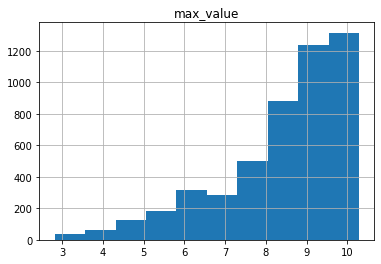

In [187]:
b_per_vals.hist(column='max_value')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b84d05340>]],
      dtype=object)

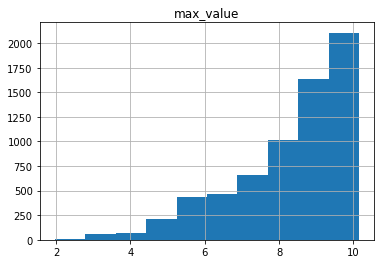

In [188]:
i_per_vals.hist(column='max_value')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b84d4b520>]],
      dtype=object)

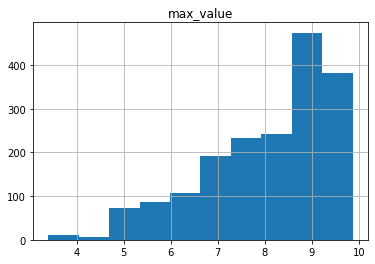

In [189]:
b_org_vals.hist(column='max_value')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b84a38580>]],
      dtype=object)

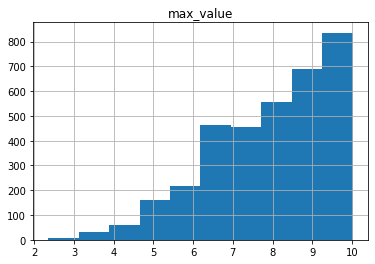

In [190]:
i_org_vals.hist(column='max_value')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b84b4ca00>]],
      dtype=object)

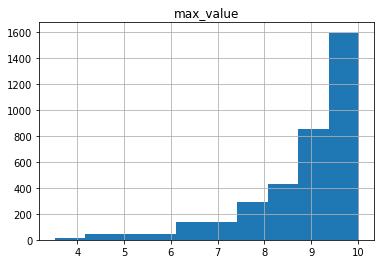

In [191]:
b_loc_vals.hist(column='max_value')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b84957220>]],
      dtype=object)

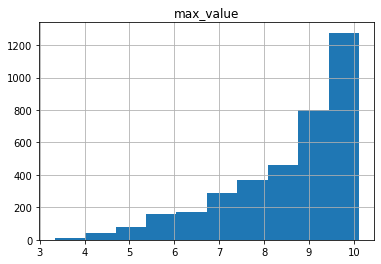

In [192]:
i_loc_vals.hist(column='max_value')